In [1]:
library("rjags")

Loading required package: coda
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [2]:
dat = read.csv(file="pctgrowth.csv", header=TRUE)

In [3]:
summary(dat)

       y                grp       
 Min.   :-5.3000   Min.   :1.000  
 1st Qu.:-0.8000   1st Qu.:2.000  
 Median : 0.0000   Median :4.000  
 Mean   :-0.1981   Mean   :3.321  
 3rd Qu.: 0.5000   3rd Qu.:5.000  
 Max.   : 2.3000   Max.   :5.000  

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 53
   Unobserved stochastic nodes: 8
   Total graph size: 128

Initializing model



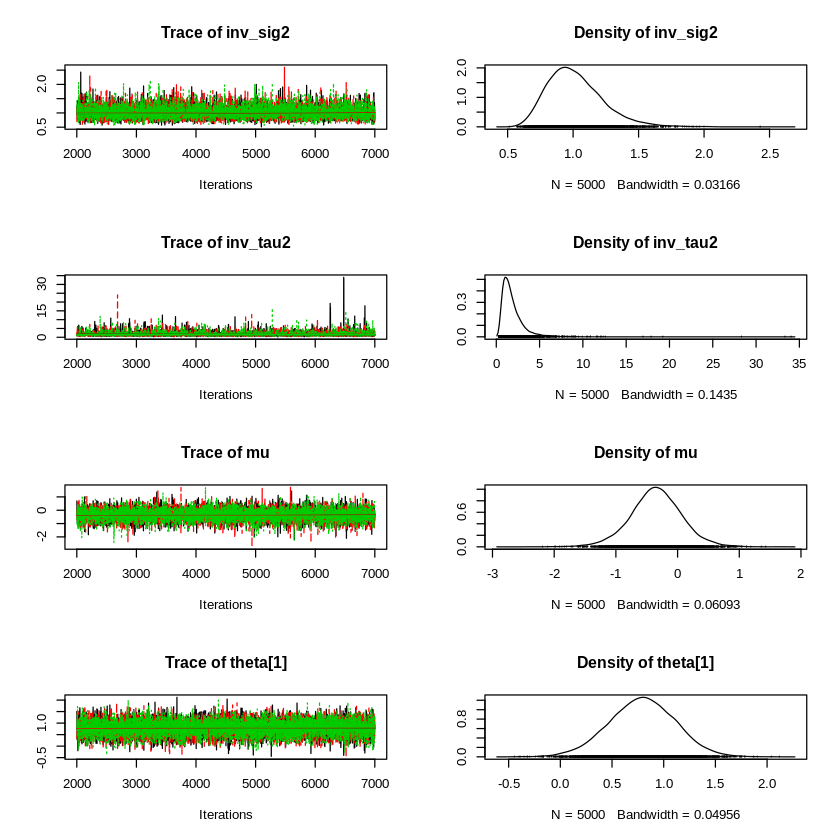

Potential scale reduction factors:

         Point est. Upper C.I.
inv_sig2       1.00       1.00
inv_tau2       1.02       1.02
mu             1.00       1.00
theta[1]       1.00       1.00
theta[2]       1.00       1.00
theta[3]       1.00       1.00
theta[4]       1.00       1.00
theta[5]       1.00       1.00

Multivariate psrf

1

,inv_sig2,inv_tau2,mu,theta[1],theta[2],theta[3],theta[4],theta[5]
Lag 0,1.000000000,1.000000000,1.000000000,1.000000000,1.0000000000,1.000000000,1.0000000000,1.000000000
Lag 1,0.325145854,0.548838539,0.113029525,0.148674443,0.1888104312,0.100163998,0.0515134011,0.024140798
Lag 5,0.021417440,0.072049989,-0.002602378,0.017778013,0.0252325886,0.027334765,0.0007717815,0.003267625
Lag 10,-0.010666038,0.005629789,0.007570282,0.006718641,-0.0073928956,-0.006392833,-0.0064731801,-0.011911854
Lag 50,0.001888647,0.009441472,-0.007174603,-0.002223923,0.0004857801,-0.006639448,0.0063033897,-0.007045587


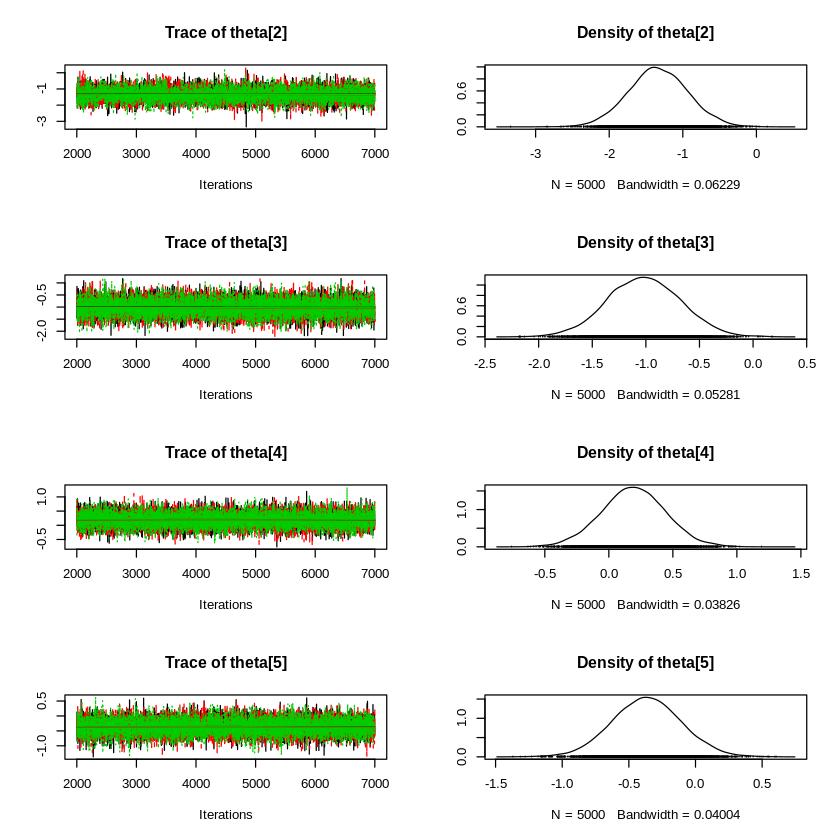

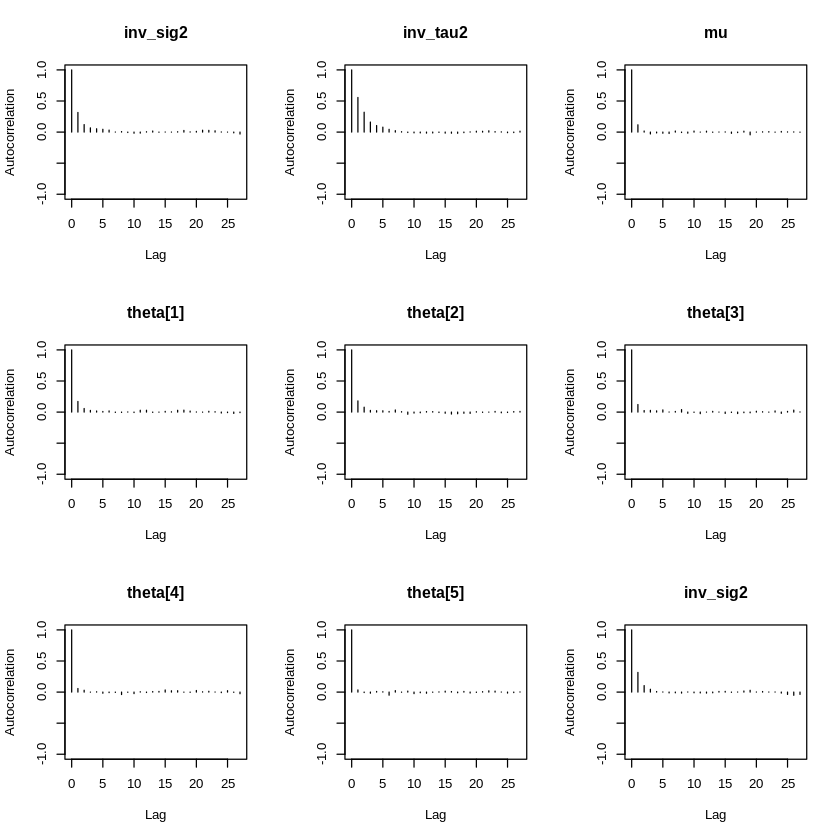

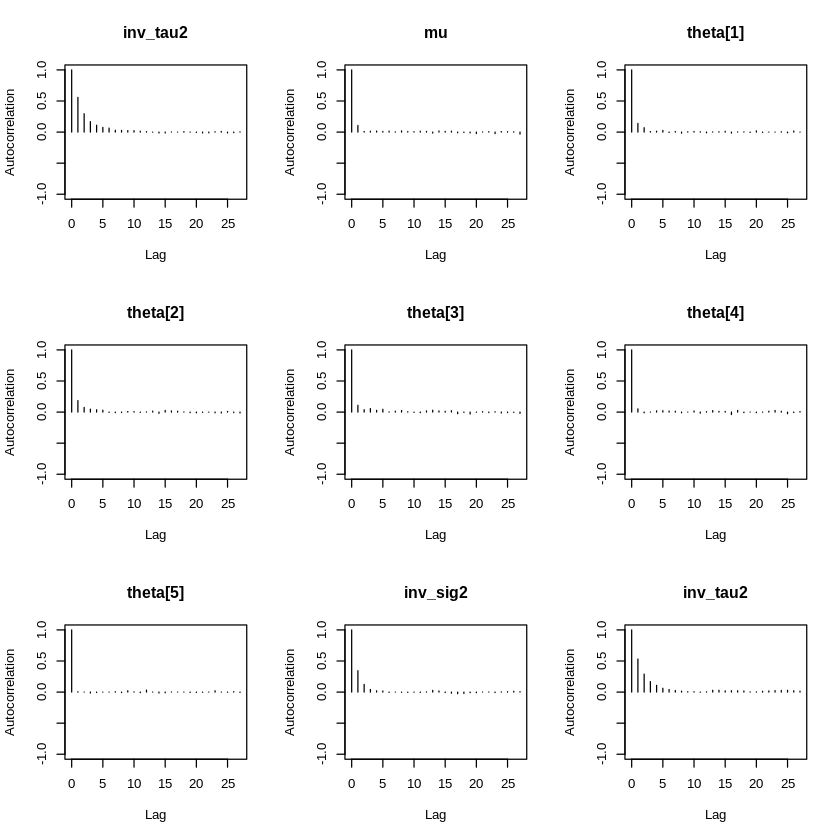

inv_sig2  inv_tau2        mu  theta[1]  theta[2]  theta[3]  theta[4]  theta[5] 
 7280.800  4217.718 11812.035 10024.652  8647.039 10207.827 13300.074 14674.106

Mean deviance:  150 
penalty 5.862 
Penalized deviance: 155.9 

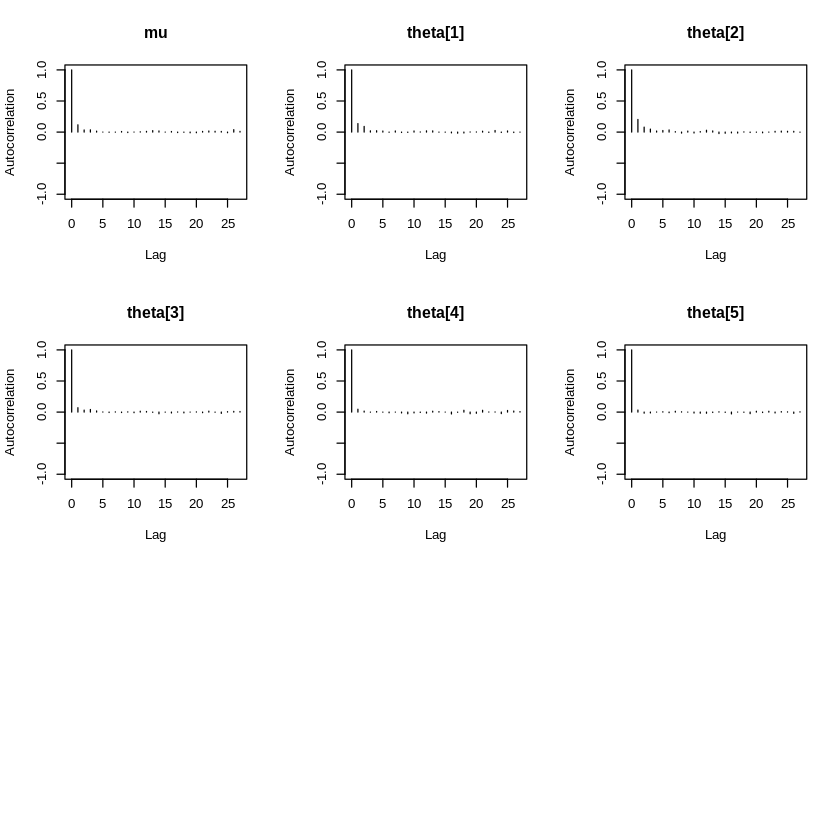

In [7]:
mod_string = " model {
    for (i in 1:length(y)) {
        y[i] ~ dnorm(theta[grp[i]], 1.0 / inv_sig2)
    }
    
    for (i in 1:5) {
        theta[i] ~ dnorm(mu, 1 / tau2)
    }

    mu ~ dnorm(0.0, 1.0/1e6)
    tau2 ~ dgamma(1.0/2.0, 1 * 3.0 / 2.0)
    sig2 ~ dgamma(2.0/2.0, 2 * 1.0 / 2.0)
    inv_tau2 = 1.0 / tau2
    inv_sig2 = 1.0 / sig2
} "

set.seed(102)

data_jags = as.list(dat)

params = c("theta", "mu", "inv_tau2", "inv_sig2")

mod = jags.model(textConnection(mod_string), data=data_jags, n.chains=3)
update(mod, 1e3)

mod_sim = coda.samples(model=mod,
                       variable.names=params,
                       n.iter=5e3)
mod_csim = as.mcmc(do.call(rbind, mod_sim))

## convergence diagnostics
plot(mod_sim)

gelman.diag(mod_sim)
autocorr.diag(mod_sim)
autocorr.plot(mod_sim)
effectiveSize(mod_sim)

## compute DIC
dic = dic.samples(mod, n.iter=1e3)
dic

In [9]:
summary(mod_csim)


Iterations = 1:15000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 15000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean     SD Naive SE Time-series SE
inv_sig2  1.0171 0.2123 0.001733       0.002431
inv_tau2  1.8448 1.3717 0.011200       0.021283
mu       -0.3500 0.4216 0.003442       0.003857
theta[1]  0.7914 0.3199 0.002612       0.003196
theta[2] -1.3353 0.4053 0.003309       0.004388
theta[3] -1.0161 0.3409 0.002783       0.003384
theta[4]  0.1918 0.2506 0.002046       0.002155
theta[5] -0.3652 0.2600 0.002123       0.002125

2. Quantiles for each variable:

            2.5%      25%     50%      75%   97.5%
inv_sig2  0.6850  0.86589  0.9911  1.13977  1.5102
inv_tau2  0.4915  1.01313  1.5077  2.25435  5.1941
mu       -1.2042 -0.61049 -0.3481 -0.08347  0.4874
theta[1]  0.1496  0.57840  0.7944  1.00711  1.4133
theta[2] -2.1263 -1.60348 -1.3411 -1.06464 -0.5330
theta[3] -1.6863 -1.24989 -1.019

In [11]:
means_anova = tapply(dat$y, INDEX=dat$grp, FUN=mean)
means_anova

1          2          3          4          5 
 0.9900000 -1.6166667 -1.1625000  0.2533333 -0.3714286

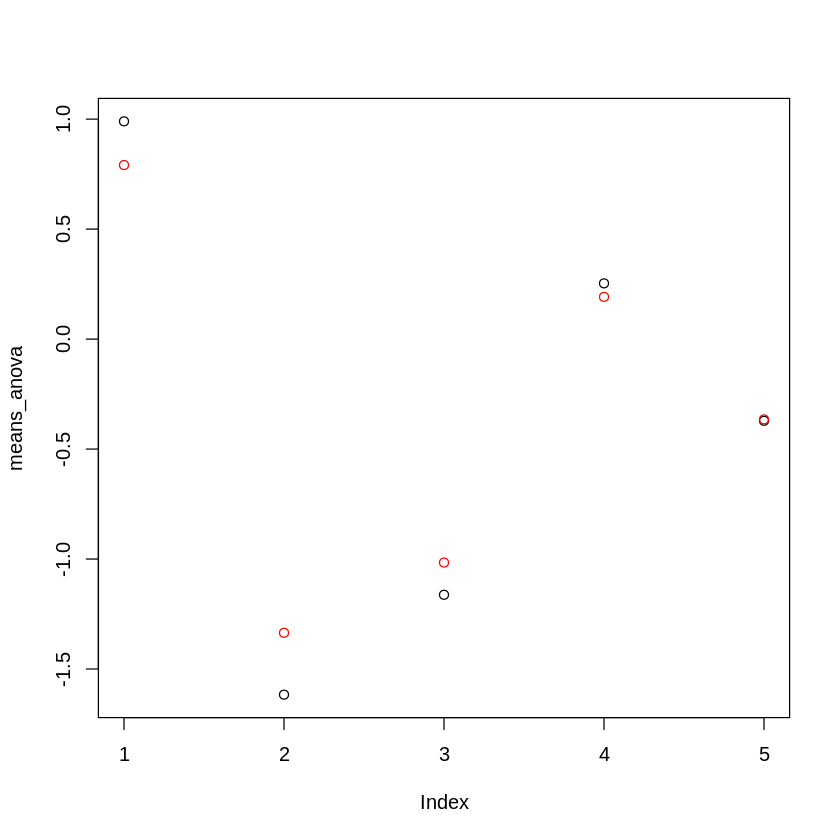

In [22]:
plot(means_anova)
points(c(mean(as.matrix(mod_sim[,4])),
         mean(as.matrix(mod_sim[,5])),
         mean(as.matrix(mod_sim[,6])),
         mean(as.matrix(mod_sim[,7])),
         mean(as.matrix(mod_sim[,8]))), col="red") ## where means_theta are the posterior point estimates for the industry means.

In [20]:
mean(as.matrix(mod_sim[,4]))

[1] 0.7913525